# Multiple Inputs: 3+ Inputs

In [1]:
import pandas as pd
import numpy as np
from keras.layers import Embedding, Input, Dense, Flatten, Concatenate
from keras.models import Model
from keras.utils import plot_model

In [2]:
games_season = pd.read_csv('data/games_season.csv')

## Shared layer with 3 inputs

<img src='data/3_inputs.png' alt='3 input and shared layer' width=500/>

In [3]:
# Count the unique number of teams
n_teams = np.unique(games_season['team_1']).shape[0]

# Create an embedding layer
team_lookup = Embedding(input_dim=n_teams,
                        output_dim=1,
                        input_length=1,
                        name='Team-Strength')

# Create an input layer for the team ID
teamid_in = Input(shape=(1,))

# Lookup the input in the team strength embedding layer
strength_lookup = team_lookup(teamid_in)

# Flatten the output
strength_lookup_flat = Flatten()(strength_lookup)

# Combine the operations into a single, re-usable model
team_strength_model = Model(teamid_in, strength_lookup_flat, name='Team-Strength-Model')

In [4]:
# Create an Input for each team
team_in_1 = Input(shape=(1,), name='Team-1-In')
team_in_2 = Input(shape=(1,), name='Team-2-In')

# Create an input for home vs away
home_in = Input(shape=(1,), name='Home-In')

# Lookup the team inputs in the team strength model
team_1_strength = team_strength_model(team_in_1)
team_2_strength = team_strength_model(team_in_2)

# Combine the team strengths with the home input using a Concatenate layer, then add a Dense layer
out = Concatenate()([team_1_strength, team_2_strength, home_in])
out = Dense(1)(out)

In [5]:
# Make a Model
model = Model([team_in_1, team_in_2, home_in], out)

# Compile the model
model.compile(optimizer='adam', loss='mean_absolute_error')

In [6]:
games_tourney = pd.read_csv('data/games_tourney.csv')

In [7]:
# Fit the model to the games_season dataset
model.fit([games_season['team_1'], games_season['team_2'], games_season['home']],
          games_season['score_diff'],
          epochs=1,
          verbose=True,
          validation_split=0.1,
          batch_size=2048)

# Evaluate the model on the games_tourney dataset
print(model.evaluate([games_tourney['team_1'], games_tourney['team_2'], games_tourney['home']],
                     games_tourney['score_diff'], verbose=False))

138/138 [==============================] - 1s 5ms/step - loss: 12.0193 - val_loss: 12.2823
11.683257102966309


## Summarizing and Plotting Models

In [8]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
Team-1-In (InputLayer)          [(None, 1)]          0                                            
__________________________________________________________________________________________________
Team-2-In (InputLayer)          [(None, 1)]          0                                            
__________________________________________________________________________________________________
Team-Strength-Model (Model)     (None, 1)            10888       Team-1-In[0][0]                  
                                                                 Team-2-In[0][0]                  
__________________________________________________________________________________________________
Home-In (InputLayer)            [(None, 1)]          0                                        

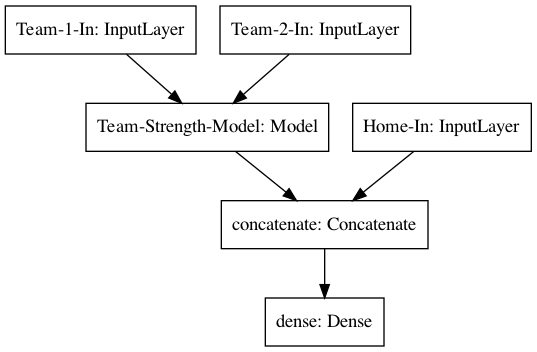

In [9]:
plot_model(model)

## Stacking Models

In [10]:
# Predict
games_tourney['pred'] = model.predict([games_tourney['team_1'],  games_tourney['team_2'], games_tourney['home']])

In [11]:
games_tourney.to_csv('data/games_tourney_2.csv', index=False)

### Create an input layer with multiple columns

In this exercise, you will look at a different way to create models with multiple inputs. This method only works for purely numeric data, but its a much simpler approach to making multi-variate neural networks.

<img src='data/enrich.png' alt='3 input and shared layer' width=500/>

In [12]:
games_tourney_train = games_tourney.loc[:int(games_tourney.shape[0]*0.8),]
games_tourney_test = games_tourney.loc[int(games_tourney.shape[0]*0.8)+1:,]

In [13]:
# Create an input layer with 3 columns
input_tensor = Input(shape=(3,))

# Pass it to a Dense layer with 1 unit
output_tensor = Dense(1)(input_tensor)

# Create a model
model = Model(input_tensor, output_tensor)

# Compile the model
model.compile(optimizer='adam', loss='mean_absolute_error')

In [14]:
# Fit the model
model.fit(games_tourney_train[['home', 'seed_diff', 'pred']],
          games_tourney_train['score_diff'],
          epochs=1,
          verbose=True)

106/106 [==============================] - 0s 4ms/step - loss: 12.8801


In [15]:
# Evaluate the model on the games_tourney_test dataset
print(model.evaluate(games_tourney_test[['home','seed_diff','pred']],
               games_tourney_test['score_diff'], verbose=False))

11.997869491577148
